# An introduction to Pytorch and Fastai v2 on the MNIST dataset.
>  Building a digit classifier with deep learning.

- toc:true
- branch: master
- badges: true
- comments: true
- author: Jonathan Sands
- categories: [deep learning, fastai, pytorch, vision, classifier]
- image: images/MNIST.jpeg

### How ?
We will build a deep learning model for digit classification on the **MNIST dataset** using the **Pytorch library** first and then using the **fastai library** based on Pytorch to showcase how easy it makes building models.

### Who does this blog post concern ?
This is addressed to people that **have basic knowledge about deep learning and want to start building models**.
I will explain some aspects of deep learning but don't expect a full course starting scratch!

### Type of model built
We won't create a brand new architecture for our neural net. Actually, in the first part using Pytorch, we will only include **linear layers** with some non-linearity between them. **No convolution** etc.. We aren't aiming at building a state of the art model.

### Why ?
I made this as part of the homework recommendation from the [Deep Learning for Coders with Fastai and PyTorch](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527) book I am currently reading. **Go check it out !**

## Downloading the data
The **fastai library provides handy functionalities** to download data and already has some urls for some famous datasets.

In [1]:
from fastai.vision.all import *
import torchvision
import torchvision.transforms as transforms
from livelossplot import PlotLosses

In [2]:
URLs.MNIST

'https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz'

Using fatai's `untar_data` procedure, we will **download** and **decompress** the data from the above url in one go. The data will **only be downloaded the first time**.

Take a look at the [documentation](https://docs.fast.ai/data.external#untar_data) if you want to learn more.

In [2]:
path = untar_data(URLs.MNIST, dest="/workspace/data")
Path.BASE_PATH = path
path.ls()

(#2) [Path('testing'),Path('training')]

As you can see, the data was **already split into a training and testing dataset** for our convenience! Let's take a peek into what is inside.

In [4]:
(path/"training").ls()

(#10) [Path('training/1'),Path('training/0'),Path('training/5'),Path('training/8'),Path('training/7'),Path('training/2'),Path('training/3'),Path('training/4'),Path('training/9'),Path('training/6')]

We have **a different directory for every digit**, each of them containing images *(see below)* of their corresponding digit.

This makes labeling easy. The **label of each image is the name of its parent directory**! 

In [5]:
(path/"training/1").ls()

(#6742) [Path('training/1/16455.png'),Path('training/1/23960.png'),Path('training/1/1816.png'),Path('training/1/14821.png'),Path('training/1/36273.png'),Path('training/1/9842.png'),Path('training/1/58767.png'),Path('training/1/12793.png'),Path('training/1/16887.png'),Path('training/1/6530.png')...]

For example, the *1* directory contains 6742 images. One is displayed below.

In [6]:
image = Image.open((path/"training/1").ls()[0])
image

In [7]:
image.size

(28, 28)

In [8]:
image.mode

'L'

This image and all the others in the data we just downloaded are **28x28 grayscale images** ('L' mode means gray-scale).

## The pytorch way

### Data preparation
#### Making pytorch datasets

In [9]:
transform = transforms.Compose(
    [transforms.Grayscale(), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
)

Above are the **transformations** we will make to each of the images when creating our Pytorch datasets.

**Step 1**: Converting into a **grayscale image**, i.e. fusing the RGB color channels into a grayscale one (from what would be a \[3, 28, 28\] tensor to a \[1, 28, 28\]).

> Tip: We need to do this because the `loader` parameter of `ImageFolder` (see next cell) loads 3 channels even if the original image only has one. I couldn't bother creating a custom loader so this does the trick.


**Step 2**: Converting the grayscale image (with pixel values in the range \[0, 255\] into a 3 dimensional \[1, 28, 28\] **pytorch tensor** (with values in the range \[0, 1\]).

**Step 3**: We normalize with mean = 0.5 and std = 0.5 to get values from pixels in the range \[-1, 1\]. (pixel = (image - mean) / std maps 0 to -1 and 1 to 1).

> Note: The argument of centering around 0 is usually held for activation functions inside the network (which we aren't doing because we are using ReLU) but I did it for the input layer because I felt like it. This is **not the same as standardizing** but still gives a zero centered range. You can read [this](https://datascience.stackexchange.com/questions/54296/should-input-images-be-normalized-to-1-to-1-or-0-to-1) and the links given for more info.

In [10]:
# Dataset on all the images from the "training" folder
full_dataset = torchvision.datasets.ImageFolder((path/"training").as_posix(), transform = transform)

# Splitting the above dataset into a training and validation dataset
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
training_set, validation_set = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

# Dataset using the "testing" folder
testing_set = torchvision.datasets.ImageFolder((path/"testing").as_posix(), transform = transform)

We just built 3 datasets. A **training** dataset, a **validation** dataset and a **testing** dataset.

Our images in the "training" folders were divided randomnly into the testing and validation dataset with a ratio of **80%** and **20%** of the images respectively.

**Testing dataset**:
Used to calculate our gradients and update our weights using the loss obtained forwarding the data through the network.

**Validation dataset**:
Used to assess model performance on unseen data during the training. We tune our hyperparameters (learning rate, batch size, number of epochs, network structure etc.) to improve this performance.

> Important: After some hyperparameter tuning, we may be satisfied with our model's performance with the validation dataset. But the thing is, we tuned these hyperparameters to fit the validation data. The mesure of performance is biased because we adapted to the validation data.


**Testing dataset**:
Used to get a final, unbiased, performance assessment. This data wasn't seen during the whole model building process.

> Warning: You can't go back and tune hyperparameters to improve this performance, because that would create the same problem as for the validation dataset.

#### From datasets to dataloaders

In pytorch, a *"Data loader combines a dataset and a sampler, and provides an iterable over the given dataset"*.
Look at [the documentation](https://pytorch.org/docs/stable/data.html) to learn more.

In [11]:
bs = 64

The `bs` variable above corresponds to the **batch size**. This is the **number of observations forwarded at a time in our neural network** (and used to calculate our mean loss and then our gradients for the training).

> Note: I chose batches of **64** because it seemed to work well for this application and my GPU isn't great so I might run out of memory with anything larger. 

In [12]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=bs, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=bs)
dataloaders = {
    "train": train_loader,
    "validation": validation_loader
}

We created a training and a testing data loader we will iterate on during our buidling process. The `shuffle` argument is set to True for the training data loader, meaning we will **reshuffle the data at every epoch**.

### Training a neural network

Deep learning is like making a dish.
I like to see the neural network's architecture as the plates / the cutlery / cooking tools, the weights as the ingredients and the hyperparameters as the cooking time / temperature / seasonning etc.

#### Creating the architecture

Without the proper tools, it would be impossible to make the dish you want and for it to be good, even if you found all the ingredients that satisfy your needs.

In [24]:
pytorch_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 50),
    nn.ReLU(),
    nn.Linear(50,10),
    nn.LogSoftmax(dim=1))

Here we chose a simple but good enough network architecture. It may not be state of the art but as you will see, it still performs quite well!

**`Flatten`**: flattens our [1,28,28] tensor into a [1,784] tensor. Our model doesn't care if it was a square image to start with, it just sees numbers, and a's long as the same pixel in our original image gets mapped to the same input variable (one of the 784 values) each time, our model will be able to learn.
We won't be doing any spatial treatment (like convolution , pooling etc.), so we just start be turning our input tensor into a feature vector that will be used by our classifier.

**`Linear`**: linear layer **with an additive bias** (`bias` parameter is set to `True` by default).

> Important: This layer **can only learn linear relations** and stacking another one doesn't change this fact since a single linear layer is capable of representing any consecutive number of linear layers.


**`ReLU`**: stands for *Rectified linear unit* is an **activation function**, also called a **nonlinearity**. It replaces every negative number with 0 (See plot below). By adding a nonlinear function between each linear layer, they become somewhat **decoupled** from each other and can each do its own useful work. Meaning with nonlinearity between linear layers **we can now learn nonlinear relations**!

**`LogSoftmax`**: applies log(Softmax(x)) to the last layer. Softmax maps all the values to [0, 1] and add up to 1 (probability distribution). log(Softmax) maps these values to [-inf, 0].

> Note: If you want to know why we use LogSoftmax instead of Softmax, you can read [this](https://deepdatascience.wordpress.com/2020/02/27/log-softmax-vs-softmax/). 

<br/>

> Note: According to our above neural network structure, our first linear layer can construct 128 different features (each representing some different mix of pixels) and our second one (decoupled from the first) can learn 50!

In [14]:
#hide
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

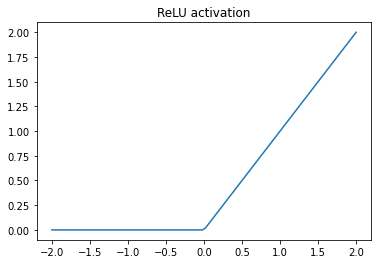

In [18]:
#hide_input
plot_function(F.relu, title="ReLU activation")

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lr = 1e-2
nb_epoch = 77

Before moving on, we should define a bunch of variables.
*"A `torch.device` is an object representing the device on which a `torch.Tensor` is or will be allocated"*. Head [here](https://pytorch.org/docs/stable/tensor_attributes.html#torch.torch.device) for more info.
Here we want to perform our computations on a GPU if it is available.

`lr` is our **learning rate** hyperparameter representing the size of the step we take when applying SGD.

`nb_epoch` is our **number of epochs**, meaning the number of complete passes through the training dataset.

> Note: I found the values for these hyperparameters to work well via trial and error. They are probably not optimal

In [25]:
optimizer = torch.optim.SGD(pytorch_net.parameters(), lr=lr)

The `optimizer` object above will **handle the stochastic gradient descent (SGD) step for us**. We need to pass it our model's parameters (so it can step on them) and a learning rate.

In [19]:
criterion = nn.NLLLoss()

We chose pytorch's `nn.NLLLoss()` for our **loss function**. It stands for *negative log likelihood loss* and is useful to train a classification problem with more than 2 classes. It **expects log-probabilities as input** for each class, which is our case after applying `LogSoftmax`.

> Tip: Instead of applying a `LogSoftmax` layer in the last layer of our network and using `NLLLoss`, we could have used `CrossEntropyLoss` instead which is a loss that combines the two into one single class. Read [the doc](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) for more.

In [20]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    liveloss = PlotLosses() # Live training plot generic API
    model = model.to(device) # Moves and/or casts the parameters and buffers to device.
    
    for epoch in range(num_epochs): # Number of passes through the entire training & validation datasets
        logs = {}
        for phase in ['train', 'validation']: # First train, then validate
            if phase == 'train':
                model.train() # Set the module in training mode
            else:
                model.eval() # Set the module in evaluation mode

            running_loss = 0.0 # keep track of loss
            running_corrects = 0 # count of carrectly classified inputs

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # Perform Tensor device conversion
                labels = labels.to(device)

                outputs = model(inputs) # forward pass through network
                loss = criterion(outputs, labels) # Calculate loss

                if phase == 'train':
                    optimizer.zero_grad() # Set all previously calculated gradients to 0
                    loss.backward() # Calculate gradients
                    optimizer.step() # Step on the weights using those gradient w -=  gradient(w) * lr

                _, preds = torch.max(outputs, 1) # Get model's predictions
                running_loss += loss.detach() * inputs.size(0) # multiply mean loss by the number of elements
                running_corrects += torch.sum(preds == labels.data) # add number of correct predictions to total

            epoch_loss = running_loss / len(dataloaders[phase].dataset) # get the "mean" loss for the epoch
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset) # Get proportion of correct predictions
            
            # Logging
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs) # Update logs
        liveloss.send() # draw, display stuff

We have our everything needed to cook our meal !
The actual cooking takes place in the above function, which handles the **training phase** and **validation phase**.

In [11]:
#hide
from fastbook import *

![Training cycle](./svg/training_cycle.svg)

The above graph illustrates what is going on during our **training phase**. We use our model to make **predictions** and calculate our **loss** (`NLLLoss` here) based on the **real labels**, then calulate the **gradients** using `loss.backward()` (computes *dloss/dx* for every parameter *x* which has `requires_grad=True`, which is the case for `nn.Parameters()` that we use under the hood) and **step the weights** with our optimizer before **repeating the process**.
The **stop condition** in our case is just the number of epochs.

> Note: You can use other stop conditions, such as a minimum accuracy to be obtained on the validation set etc.


The **validation phase** is basically the same process without calculating gradients and stepping since we are only intersted on measuring model performance.

> Tip: Be sure to call model.train() and model.eval() before the corresponding phase. Some layers like `BatchNorm` and `Dropout` have a different behavior during training and evaluation. This is not the case of our model but it is still good habit)

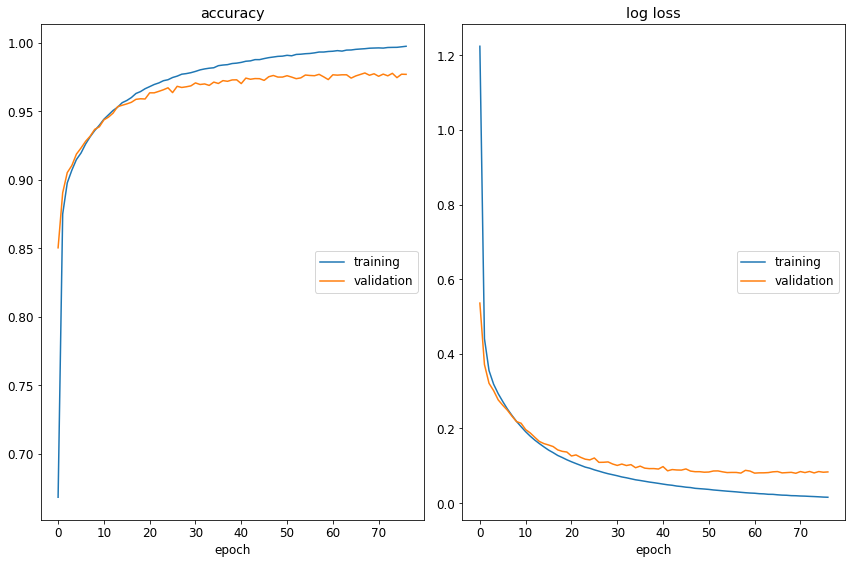

accuracy
	training         	 (min:    0.668, max:    0.998, cur:    0.998)
	validation       	 (min:    0.850, max:    0.978, cur:    0.977)
log loss
	training         	 (min:    0.015, max:    1.224, cur:    0.015)
	validation       	 (min:    0.080, max:    0.536, cur:    0.083)


In [26]:
train_model(pytorch_net, criterion, optimizer, dataloaders, nb_epoch)

After 80 epochs we get **97.7% accuracy** on the validation data, which is very good for a simple model such as this one!

Even though our validation loss and accuracy stabilized themselves after around 50 epochs, I kept going for a couple epochs just in case I could squeeze a bit more out.

> Note: Notice how training loss is close to 0 and accuracy nearly at 100%. This means our network nearly perfectly memorized the entire training data.

<br/>

> Tip: Plotting metrics such as accuracy and loss lets you visualize the process and helps with parameter tuning (what could be causing spikes? Is the accuracy going up / down or has it reached a plateau? etc.)

<br/>

> Warning: If validation loss started to go up and validation accuracy started to go down after some time, that would be signs of overfitting! Models using architectures with more layers take longer to train, and are more prone to overfitting. Training on small amount of data makes memorizing easier and can also lead to overfitting. **Be careful!**

In [27]:
torch.save(pytorch_net, 'models/pytorch-97.7acc.pt')

Let's **save** our trained model for inference using `torch.save`.

> Warning: This saves the entire module using Python's [pickle](https://docs.python.org/3/library/pickle.html) module. There are disadvantages to this approach. I used it here because it is more intuitive and is not the focus of this blog post, but feel free to read [this official pytorch document](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to learn more about use cases regarding the saving and loading of Pytorch models.

## The Fastai way
*"fastai is a deep learning library which provides practitioners with high-level components that can quickly and easily provide state-of-the-art results in standard deep learning domains, and provides researchers with low-level components that can be mixed and matched to build new approaches."*. 

Read [the docs](https://docs.fast.ai) to learn more!
### Data preparation

In [4]:
block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        batch_tfms=aug_transforms(mult=2., do_flip=False))

The `DataBlock` class is a *"generic container to quickly build `Datasets` and `DataLoaders`"*.

- **`blocks`**: This is the way of telling the API that our inputs are images and our targets are categories. Types are represented by blocks, here we use `ImageBlock` and `CategoryBlock` for inputs and targets respectively.

- **`get_items`**: expects a function to assemble our items inside the data block. `get_image_files` searches subfolder for all image filenames recursively.

- **`splitter`**: Controls how our validation set is created. `RandomSplitter` splits items between training and validation (with `valid_pct` portion in validation) randomnly.

- **`get_y`**: expects a function to label data according to file name. `parent_label` labels items with the parent folder name.

- **`batch_tfms`**: These are transformations applied to batched data samples on the GPU. `aug_transforms` is an *"utility function to create a list of flip, rotate, zoom, warp and lighting transforms"*. (Here we disabled flipping because we don't want to train on mirrored images and use twice the amount of augmentation compared to the default.) These augmentations are only done on the training set, we don't want to evaluate our model's performance on distorted images.

> Note:  *"Our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.<br/>In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing! So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image."* (Deep Learning for Coders with Fastai and PyTorch)


This **doesn't acutally build the datasets and data loaders** since we didn't actually gave it our images yet. But once we do, it knows exactly how to deal with them!

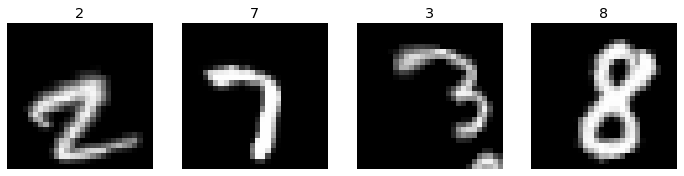

In [11]:
loaders = block.dataloaders(path/"training")
loaders.train.show_batch(max_n=4, nrows=1)

`block.dataloaders` creates a `DataLoaders` object from the source we give it. Here we gave it the *training* folder.
The sample of images shown are outputs from the created training data loader. As you can see, they are correctly labeled and quite **distorted due to the batch augmentations** we made.

We use the default value of **64 for our batch size** (`bs` parameter).

### Training a neural network

In [23]:
learn = cnn_learner(loaders, resnet34, metrics=accuracy)

`cnn_learner` builds a **convolutional neural network** style learner from dataloaders and an architecture. In our case we use the *ResNet* architecture. The 34 refers to the number of layers in this variant of the architecture.

`cnn_learner` has a parameter called `pretrained` which defaults to `True`, that sets the weights in our model to values **already trained** by experts to recognize thousands of categories on the [ImageNet dataset](http://www.image-net.org/).

When using a **pretrained model**, cnn_learner will **remove the last layer** since that is always specifically customized to the original training task (i.e. ImageNet dataset classification), and replace it with one or more new layers with randomized weights (called the **head**), of an appropriate size for the dataset you are working with.

> Tip: "You should nearly always use a pretrained model, because it means that your model, before you've even shown it any of your data, is already very capable. And, as you'll see, in a deep learning model many of these capabilities are things you'll need, almost regardless of the details of your project. For instance, parts of pretrained models will handle edge, gradient, and color detection, which are needed for many tasks." (Deep Learning for Coders with Fastai and PyTorch)


SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.007585775572806597)

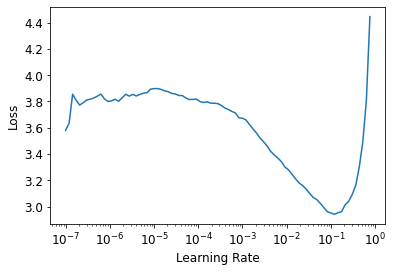

In [17]:
learn.lr_find()

`learn.lr_find()` **explores learning rates** in a given range ([1e-7, 10] by default) over a number of iterations (100 default) and plots the loss versus the learning rates on a log scale.

> Tip: A rule of thumb is choosing a value that is approximately in the middle of the sharpest downward slope (around 1e-2 here). You can also use the `lr_min` and `lr_steep` indicators above and choose a learning rate between them.

epoch,train_loss,valid_loss,accuracy,time
0,0.720954,0.305432,0.901917,01:00


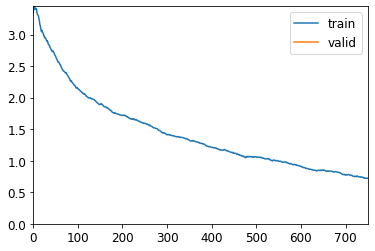

epoch,train_loss,valid_loss,accuracy,time
0,0.206855,0.076552,0.978250,01:24
1,0.154104,0.069363,0.978500,01:23
2,0.122340,0.059505,0.983250,01:23
3,0.110277,0.044111,0.987417,01:23
4,0.091840,0.049989,0.985250,01:23
5,0.074792,0.027301,0.992833,01:23
6,0.071336,0.025267,0.992167,01:23
7,0.065276,0.027973,0.991917,01:23
8,0.043457,0.026573,0.991833,01:25
9,0.041340,0.019284,0.994500,01:25


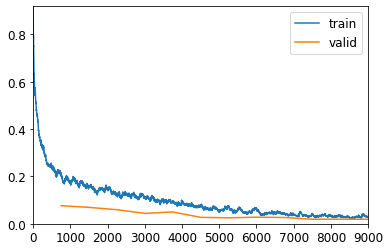

In [24]:
learn.fine_tune(12, base_lr=1e-2, cbs=[ShowGraphCallback()])

`learn.fine_tune`: *"Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` for `epochs` using discriminative LR"* ([docs](https://docs.fast.ai/callback.schedule#Learner.fine_tune))

By default a pretrained `Learner` is in a **frozen state**, meaning that **only the head of the model will train** while the body stays frozen.

To resume, `fine_tune` trains the head (automatically added by `cnn_learner` with random weights) without the body for a few epochs (defaults to 1) and then unfreezes the `Learner` and trains the whole model for a number of epochs (here we chose 12) using **discriminative learning rates** (which means it applies different learning rates for different parts of the model).

`cbs` expects a list of callbacks. Here we passed `ShowGraphCallback` which updates a graph of training and validation loss (as seen above).

> Note: Discriminative learning rate is preferred on pretrained models since the early layers are already trained and already recognize features useful to our specific model. This means we don't need to train these layers *"as hard"* (updating weights by smaller steps), which is why we use a range of learning rates from smaller ones for early layers to larger ones for later layers.

**CONGRATS!**

After training our model for a while, we get around **99.5%** accuracy on our validation set with minimal effort!

In [43]:
learn.export("models/fastai-99acc.pkl")

`learn.export` **saves** the definition of **how to create our `DataLoaders`** on top of saving the **architecture and parameters** of the model.
Saving the `Dataloaders` allows us to transform the data for inference in the same manner as our validation set by default, so data augmentation will not be applied.

In [40]:
interp = ClassificationInterpretation.from_learner(learn)

`ClassificationInterpretation.from_learner()` constructs an `ClassificationInterpretation` object from a `learner`.
It gives a handful of **interpretation methods** for classification models.

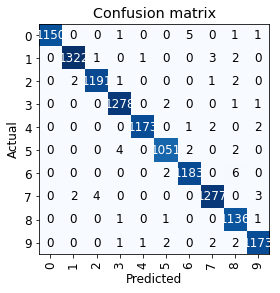

In [39]:
interp.plot_confusion_matrix()

The above **confusion matrix** helps us visualize where our model made mistakes. It like the most confused number were 0 with 6, 6 with 8, 5 with 3 and 7 with 2.

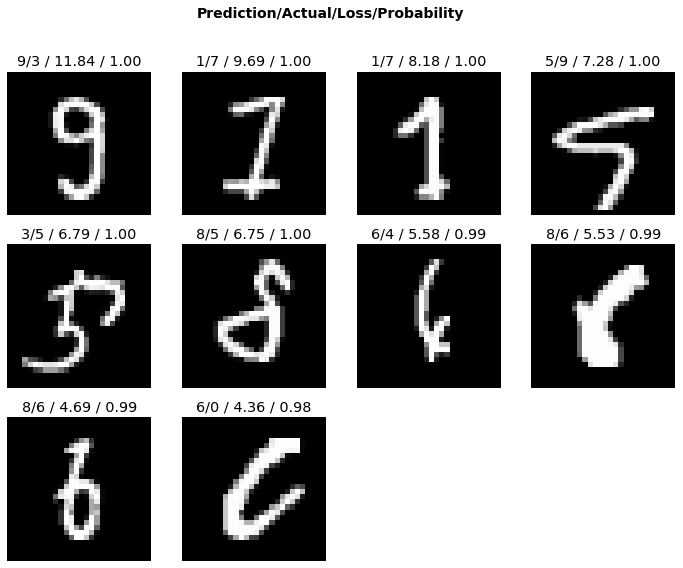

In [38]:
interp.plot_top_losses(10)

We can also visualize which images resulted in the **largest loss**.
It seems like the upper-left 9 was **mislabeled** as a 3, so our network was right.
For some of those, even humans could have mistaken them !

## Evaluating our model's inference on the testing dataset!

### Pytorch model

In [29]:
def test_model(model, criterion, test_loader):
    model = model.to(device) # Moves and/or casts the parameters and buffers to device.
    test_loss = 0.0 # keep track of loss
    test_corrects = 0 # count of carrectly classified inputs

    with torch.no_grad(): # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs = inputs.to(device) # Perform Tensor device conversion
            labels = labels.to(device)
        
            outputs = model(inputs) # forward pass through network
            loss = criterion(outputs, labels) # Calculate loss
         
            _, preds = torch.max(outputs, 1)
        
            test_loss += loss * inputs.size(0) # multiply mean loss by the number of elements
            test_corrects += torch.sum(preds == labels.data) # add number of correct predictions to total
    
        avg_loss = test_loss / len(test_loader.dataset) # get the "mean" loss for the epoch
        avg_acc = test_corrects.float() / len(test_loader.dataset) # Get proportion of correct predictions
    
    return avg_loss.item(), avg_acc.item()

Our **testing procedure** is basically the **same as our validation phase** from the training procedure apart from the **absence of epochs**. (To be expected since they serve the same purpose!)

We **infer** predictions from our inputs by batches, then calculate the loss from them (how *"far"* they were from the real labels) and record the loss and the number of correctly labeled inputs, before averaging it all at the end.

In [30]:
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=bs)

Creation of a testing `DataLoader` to be passed to our testing procedure.

In [31]:
pytorch_loss, pytorch_accuracy = test_model(pytorch_net, criterion, testing_loader)

In [8]:
def print_loss_acc(loss, acc):
    print("Loss : {:.6f}".format(loss))
    print("Accuracy : {:.6f}".format(acc))

In [33]:
print_loss_acc(pytorch_loss, pytorch_accuracy)

Loss : 0.079889
Accuracy : 0.977300


The results on the **testing data** are approximately the same as on the validation set!

### Fastai model

In [4]:
learn = load_learner('models/fastai-99acc.pkl')

In [5]:
test_dl = learn.dls.test_dl(get_image_files(path/"testing"), with_labels=True)

`test_dl` creates a **test dataloader** from `test_items` (list of image paths) using validation transforms of `dls`.
We set `with_labels` to `True` because we want the labels of each image to **check the inference accuracy of our model**.

In [6]:
fastai_loss, fastai_accuracy = learn.validate(dl=test_dl)

`learn.validate` returns the **calculated loss** and the **metrics** of the model on the `dl` data loader.

In [10]:
print_loss_acc(fastai_loss, fastai_accuracy)

Loss : 0.014902
Accuracy : 0.995400


Our **loss** and **accuracy** are slightly better than on our validation set!

> Note: A better loss and accuracy on the testng dataset may suggest that the makers of the MNIST database chose more of the hard and ambiguous images for training in order to make the trained models more robust.

**And that's about it! Not so hard heh!**
We now have a two digits classification models **ready to be used for inference**!

## How was it ?

This is one of my first blog posts and it took me some time. **Any feedback is welcome**!

Was the whole model building process easier than expected?

Would you have done some parts a different way?

Was my explaination any good?

Please feel free to **comment or annotate the text directly using Hypothes.is if you spotted any errors or have any questions!**